Mini-projet : Interpolation de Données Manquantes
==============================

*Contexte* : dans le cadre d'acquisition de données sismiques, des capteurs (récepteurs) sont positionnés le long d'une ligne à la surface de la terre. Chacun enregistre au cours du temps le déplacement des particules (signal oscillant) qui varie lors du passage d'une onde acoustique ou élastique. Cet enregistrement s'appelle une **trace**. Chaque trace correspond à une *colonne* de l'image presentée au début de la section 2 (une seule position spatiale, un signal qui dépend du temps).

En pratique, il arrive que certains capteurs sont défaillants ou encore qu'ils ne sont pas présents dans certaines zones (pour des problèmes d'accessibilité par exemple). L'objectif principal du mini-projet est de reconstituer les traces manquantes.

*Hypothèses* : nous ferons l'hypothèse importante que les **signaux d'une trace peuvent être *localement* prédits à partir d'une trace voisine, par un simple décalage temporel** (voir la partie "Première Analyse" pour une définition précise). 

*Notions abordées* : 
* Analyse des signaux dans le domain d'origine ;
* Analyse des signaux après transformée de Fourier 2d ;
* Régularisation et formulation sous forme de problème inverse.

Pour cela, trois approches sont considerées :
* *Approche 1* : analyse dans le domaine $(x,t)$ : identification de 3 temps et de 3 pentes, sélection d'une ondelette source, prédiction des données manquantes ;
* *Approche 2* : transformée de Fourier 2d, identification des événements principaux, définition d'un masque et reconstitution des traces manquantes ;
* *Approche 3* (optionelle) : suite de l'approche 2 pour s'assurer que la prédiction respecte bien les observables. Elle se fait au travers de la résolution d'un problème inverse avec ajout de régularisation.

*Attentes* :
* Développement des approches 1 et 2 sur des données fournies ici ;
* Discusssion sur une comaparaison entre les approches 1 et 2, en particulier sur les avantages et limites des approches. Application de l'approche 1 ou 2 sur un exemple que vous pourrez créer vous-mêmes.

*Consignes* :
* **Très important** : pour toutes les figures, bien indiquer les axes avec les bonnes unités et des labels lisibles ;
* L'approche 3 est optionnelle.

In [413]:
import numpy as np
import matplotlib.pyplot as plt
# Only for question 4 (optional)
from scipy.optimize import minimize
from itertools import product

**Lecture des données**

In [414]:
# Labelsize (display)
labelsize   = 14
    
# Load the input data
# Input data (with missing traces)
gpanel = np.load('gpanel.npy')
# Dense data (with all traces, only for comparison)
panel_dense = np.load('panel_dense.npy')
nt, nx = gpanel.shape
print("Dimension des panneaux (axes temps et espace):",nt,nx)

# Missing traces (index number)
mtr = [2,5,6,11,12,20,21,22,23]

# Vertical axis -- time
dt   = 3.125e-3  # increment (s)
at   = np.linspace(0,dt*(nt-1),nt)
# Horizontal axis -- space
dx   = 10. # increment (m)
ax   = np.linspace(0,dx*(nx-1),nx)

Dimension des panneaux (axes temps et espace): 400 30


**Affichage des données**

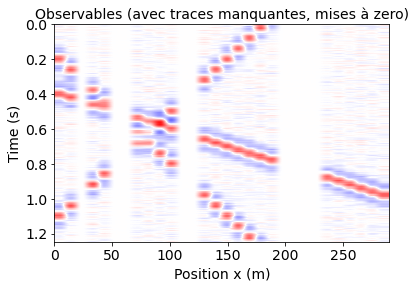

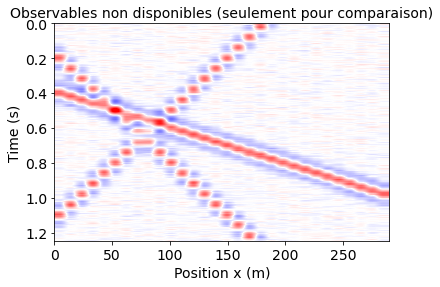

In [415]:
# Display of the input data
vmax    = np.max(np.abs(gpanel))
fig = plt.figure()
av = plt.subplot(111)
plt.imshow(gpanel,extent=[ax[0],ax[-1],at[-1],at[0]],aspect='auto')
plt.title('Observables (avec traces manquantes, mises à zero)', fontsize = labelsize)
av.set_ylabel("Time (s)", fontsize = labelsize)
av.set_xlabel("Position x (m)", fontsize = labelsize)
av.tick_params(axis='both', which='major', labelsize=labelsize)
plt.clim([-vmax,vmax])
plt.set_cmap('bwr')

fig = plt.figure()
av = plt.subplot(111)
plt.imshow(panel_dense,extent=[ax[0],ax[-1],at[-1],at[0]],aspect='auto')
plt.title('Observables non disponibles (seulement pour comparaison)', fontsize = labelsize)
av.set_ylabel("Time (s)", fontsize = labelsize)
av.set_xlabel("Position x (m)", fontsize = labelsize)
av.tick_params(axis='both', which='major', labelsize=labelsize)
plt.clim([-vmax,vmax])
plt.set_cmap('bwr')

# Première Analyse
* Dans les 2 images plus haut, 3 événements principaux ressortent. Ils sont associés à 3 temps différents (pour $x = 0$ m) et à 3 pentes différentes représentées ici :

<img src="data.png" width="400">

* Nous ferons l'hypothèse que ces événements sont linéaires, c'est-à-dire qu'il est possible de prédire une trace à une position $x$ connaissant les temps $t_i$ à la position $x_0 = 0$ m, les pentes $p_i$ et une fonction $S(t)$ appelee ondelette source  :
$$u(t,x) \simeq \sum_{i=1}^{3} S(t - t_i - p_i(x-x_0))$$

* Quelle est l'unité des pentes $p_i$? Donner les valeurs approximatives de ces 3 pentes $p_i$ et des 3 temps $t_i$.

**Aliasing spatial**

Sur l'image suivante, des événements sont visibles à gauche, avec une pente bien visible $p_1$. Sur la partie de droite de l'image, deux pentes sont identifiables $p_2$ et $p_3$. Pourtant on peut suivre des événement de gauche à droite : c'est l'effet d'aliasing spatial.

<img src="aliasing.png" width="400">

Construisez des données comme suit, avec les mêmes échantillonages temporel et spatial que sur l'exemple avec les données manquantes : 
$$d(t,x) = \sin(2 \pi f_c (t - p\cdot x))$$
$f_c$ est la fréquence caractéristique du signal (pour l'obtenir, calculer les spectres de plusieurs traces et déterminer $f_c$ comme valeur pour laquelle le spectre est en moyenne le plus grand). Tracer $d(t,x)$ pour différentes valeurs de $p$, en commençant par $p=0$. La pente visible dans les données augmente avec $p$, jusqu'à un certain moment : c'est l'effet d'aliasing spatial. Est-il possible de retrouver le cas $p=0$ pour un $p$ non nul? A partir des observations, proposer un critère à respecter pour éviter l'aliasing spatial. Ce critère est une relation entre $p$, $f_c$ et la distance $dx$ (ici 10 m) entre 2 traces consécutives. Vérifier si les pentes $p_i$ conduisent ou pas à de l'aliasing spatial.

### Pentes

<font color=blue>

La pente est en $ s.m^{-1} $. 
    
Par lecture sur l'image, elles valent approximativement :
- $p_1 =  -0.002 s.m^{-1}$
- $t_1 = 0.4s$
- $p_2 = 0.006 s.m^{-1} $
- $t_2 = 1.1s$
- $p_3 = -0.006 s.m^{-1} $ 
- $t_3 = 0.2s$


In [417]:
p1 = -0.002
t1 = 0.4
p2 = 0.006
t2 = 1.1
p3 = -0.006
t3 = 0.2

### Calcul de $f_c$

<font color=blue>

On calcule d'abord la fréquence $f_c$ en regardant le spectre sur plusieurs échantillons et en faisant une moyenne des valeurs trouvées :

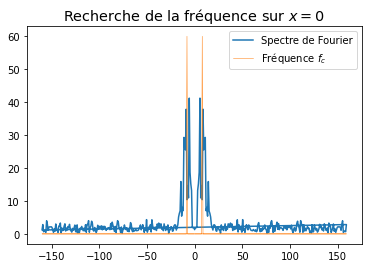

In [418]:
signal = panel_dense[:,0]
signal_fourier = np.fft.fft(signal)
n = signal.size
freq = np.fft.fftfreq(n, at[1]-at[0])
#ax = plt.axes()
plt.plot(freq, np.abs(signal_fourier), label="Spectre de Fourier")
fc = []
for f in freq :
    if 7.9<= np.abs(f) <= 8.1:
        fc.append(60)
    else :
        fc.append(0)
plt.plot(freq, fc, linewidth = 0.5, label = "Fréquence $f_c$")
#ax.set_ylabel('Amplitude (ua)')
#ax.set_xlabel('Fréquence (Hz)')
plt.legend()
plt.title('Recherche de la fréquence sur $x=0$', fontsize = "x-large")
plt.show();

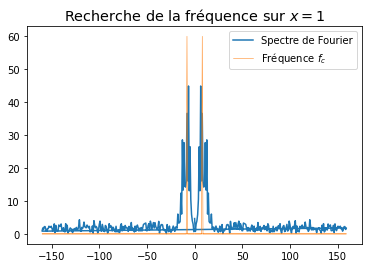

In [419]:
signal = panel_dense[:,1]
signal_fourier = np.fft.fft(signal)
n = signal.size
freq = np.fft.fftfreq(n, at[2]-at[1])
#ax = plt.axes()
plt.plot(freq, np.abs(signal_fourier), label = "Spectre de Fourier")
fc = []
for f in freq :
    if 7.9<= np.abs(f) <= 8.1:
        fc.append(60)
    else :
        fc.append(0)
plt.plot(freq, fc, linewidth = 0.5, label = "Fréquence $f_c$")
#ax.set_ylabel('Amplitude (ua)')
#ax.set_xlabel('Fréquence (Hz)')
plt.legend()
plt.title('Recherche de la fréquence sur $x=1$', fontsize = "x-large")
plt.show();

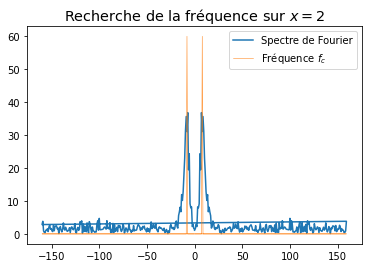

In [420]:
signal = panel_dense[:,2]
signal_fourier = np.fft.fft(signal)
n = signal.size
freq = np.fft.fftfreq(n, at[3]-at[2])
#ax = plt.axes()
plt.plot(freq, np.abs(signal_fourier), label = "Spectre de Fourier")
fc = []
for f in freq :
    if np.abs(f) == 8:
        fc.append(60)
    else :
        fc.append(0)
plt.plot(freq, fc, linewidth = .5, label = "Fréquence $f_c$")
#ax.set_ylabel('Amplitude (ua)')
#ax.set_xlabel('Fréquence (Hz)')
plt.legend()
plt.title('Recherche de la fréquence sur $x=2$', fontsize = "x-large")
plt.show();


<font color=blue>

On trouve $f_c = 8 \text{Hz}$

In [421]:
fc = 8

### Caractéristiques de $d(t,x)$

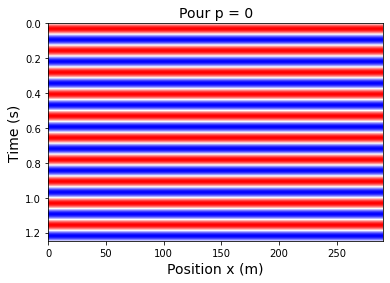

In [422]:
p = 0
d = np.array([[np.sin(2*np.pi*fc*(t-p*x)) for x in ax] for t in at])
plt.title('Pour p = 0', fontsize = labelsize)
plt.ylabel("Time (s)", fontsize = labelsize)
plt.xlabel("Position x (m)", fontsize = labelsize)
plt.imshow(d, extent=[ax[0],ax[-1],at[-1],at[0]],aspect='auto');

<font color=blue>

On trace $d(t,x)$ :

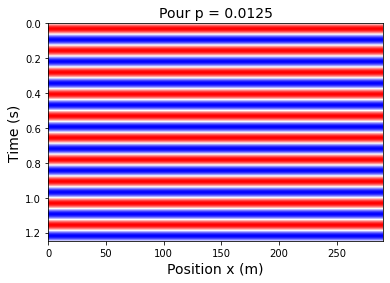

In [423]:
# Le p minimal tel qu'on retrouve le même motif que pour p=0 est :
p = 0.0125
d = np.array([[np.sin(2*np.pi*fc*(t-p*x)) for x in ax] for t in at])
plt.title('Pour p = 0.0125', fontsize = labelsize)
plt.ylabel("Time (s)", fontsize = labelsize)
plt.xlabel("Position x (m)", fontsize = labelsize)
plt.imshow(d, extent=[ax[0],ax[-1],at[-1],at[0]],aspect='auto');

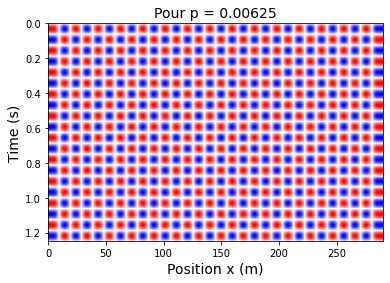

In [424]:
# A partir de 0.00625, l'aliasing est présent.
p = 0.00625
d = np.array([[np.sin(2*np.pi*fc*(t-p*x)) for x in ax] for t in at])
plt.title('Pour p = 0.00625', fontsize = labelsize)
plt.ylabel("Time (s)", fontsize = labelsize)
plt.xlabel("Position x (m)", fontsize = labelsize)
plt.imshow(d, extent=[ax[0],ax[-1],at[-1],at[0]],aspect='auto');

<font color="blue"> 

La relation pour avoir un critère de non-aliasing avec les données $f_c$, $p$ et $dx$ est :
$$ 0.0125 n \le p = \frac{1}{f_c dx} \le 0.0125 \dfrac{(n+1)}{2} $$

<font color="blue"/>

On vérifie si les pentes $p_i$ conduisent à un aliasing spatial :


<font color="blue">

La pente maximale pour qu'il n'y ait pas d'aliasing est de $ 0.00625$ Or les pentes estimées sont au maximum égale à $0.006$, on peut donc penser que le phénomène d'aliasing va être un problème pour les pentes les plus fortes.

# Approche 1 : Reconstitution des Données dans le Domaine $(x,t)$

## Détermination de $S(t)$

Sélectionner une trace (par exemple pour $x$ autour de 250 m et déterminer $S(t)$ avec l'hypothèse que $S(t)$ est maximale pour $t=0$. Prendre pour le support de $S$ une fenêtre de longueur autour de 0.2 s. Afficher le résultat.

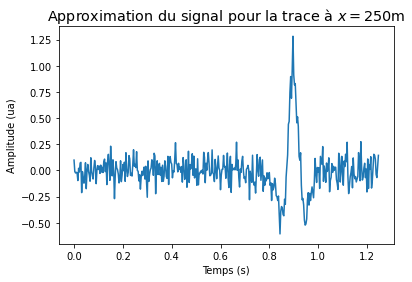

In [491]:
trace_25 = gpanel[:,25]
plt.plot(at,trace_25)
plt.ylabel('Amplitude (ua)')
plt.xlabel('Temps (s)')
plt.title("Approximation du signal pour la trace à $x=250$m", fontsize = "x-large")
plt.show()

<font color="blue"/>

D'après la formulation dans la partie introductive, la signal est approximé par une somme de fonction $S$. Ici, on travaille sur la $25^{ème}$ colonne, on peut voir que le signal est nul sauf au point d'intersection de la droite et de la colonne. Il s'agit donc d'une indicatrice à ce point d'intersection c'est à dire quand $t-t_i-p_i(x-x_0) = 0$ avec ici $x=250$.
On propose donc : $S(t) = \sum_i \mathbb{1}_{t-t_i-p_i(x-x_0) \in [-0.1, 0.1]}$

In [492]:
def S(ti, pi, t, x) :
    if -0.1 <= t-ti+pi*x <= 0.1: # on a bien une fenêtre de longueur 0.2s
        return 1
    else :
        return 0

In [493]:
def ondelette_ind(t, sigma, mu, debut, fin) :
    A = 2/(np.sqrt(3*sigma)*np.pi**(1/4))
    if debut <= t <= fin :
        return A * (1-((t-mu)/sigma)**2) * np.exp(-(t-mu)**2/(2*sigma**2))
    else :
        return 0

In [494]:
def ondelette_ind2(ti, pi, t, x, sigma, mu) :
    A = 2/(np.sqrt(3*sigma)*np.pi**(1/4))
    return A * (1-((t-mu)/sigma)**2) * np.exp(-(t-mu)**2/(2*sigma**2))*S(ti,pi,t,x)*max(gpanel[:,x//10])

<font color="blue"/>
On essaie d'abord avec une indicatrice pour récupérer seulement le pic.

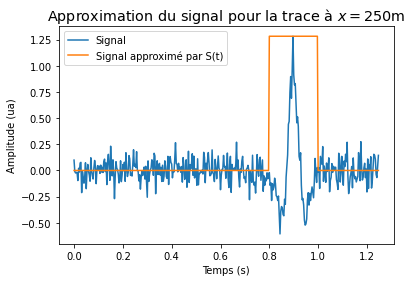

In [495]:
#fig, ax = plt.subplots()
plt.plot(at, trace_25, label = "Signal");
plt.plot(at, [max(gpanel[:,25])*S(0.4, -0.002, t, 250) for t in at], label = "Signal approximé par S(t)");
plt.ylabel('Amplitude (ua)')
plt.xlabel('Temps (s)')
plt.legend()
plt.title("Approximation du signal pour la trace à $x=250$m", fontsize = "x-large")
plt.show();

<font color="blue"/>
On essaie maintenant de mieux approximer le pic grâce au chapeau méxicain.

https://fr.abcdef.wiki/wiki/Mexican_hat_wavelet

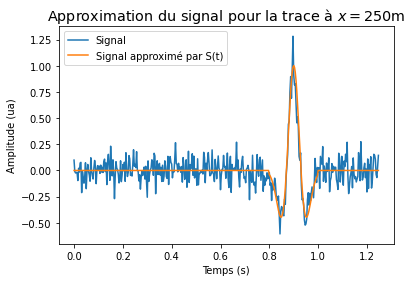

In [496]:
#fig, ax = plt.subplots()
plt.plot(at, trace_25, label = "Signal");
plt.plot(at, [1/5*ondelette_ind(t, 0.03, 0.9, 0.8, 1) for t in at], label = "Signal approximé par S(t)")
plt.ylabel('Amplitude (ua)')
plt.xlabel('Temps (s)')
plt.legend()
plt.title("Approximation du signal pour la trace à $x=250$m", fontsize = "x-large")
plt.show();

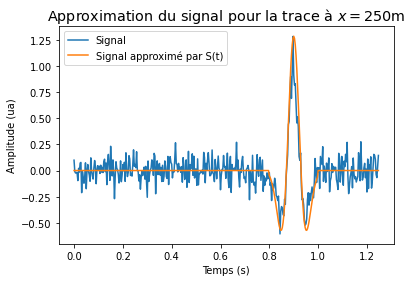

In [497]:
#fig, ax = plt.subplots()
plt.plot(at, trace_25,label = "Signal");
plt.plot(at, [1/5*ondelette_ind2(t1, p1, t, 250, 0.03, 0.9) for t in at], label = "Signal approximé par S(t)")
plt.ylabel('Amplitude (ua)')
plt.xlabel('Temps (s)')
plt.legend()
plt.title("Approximation du signal pour la trace à $x=250$m", fontsize = "x-large")
plt.show();

On obtient une meilleure approximation avec ondelette_ind2, en effet on multiplie l'ondelette par le signal S(t) ainsi ils ont la même amplitude. L'ondelette de Ricker s'appliquant sur des fonctions normalisées?

### Reconstruction du signal à x donné

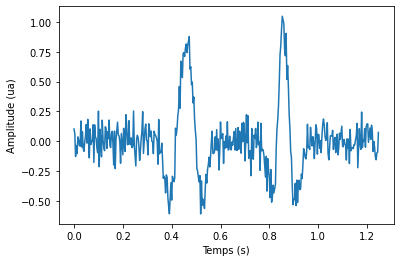

In [498]:
plt.plot(at, gpanel[:,4],label = "Signal")
plt.ylabel('Amplitude (ua)')
plt.xlabel('Temps (s)')
plt.show()

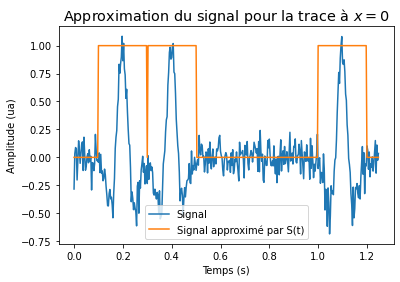

In [499]:
xdonne = 0
x = xdonne*10
#fig, ax = plt.subplots()
plt.plot(at, gpanel[:,xdonne],label = "Signal");
signal_const = [S(t1, p1, t, x)+S(t2, p2, t, x)+S(t3, p3, t, x) for t in at]

# Gérer le chevauchement
for i in range(len(signal_const)):
    if signal_const[i] >= 1 :
        signal_const[i] = 1
    

plt.plot(at, signal_const, label = "Signal approximé par S(t)")
plt.ylabel('Amplitude (ua)')
plt.xlabel('Temps (s)')
plt.legend()
plt.title("Approximation du signal pour la trace à $x=0$", fontsize = "x-large")
plt.show();

### Chapeau mexicain

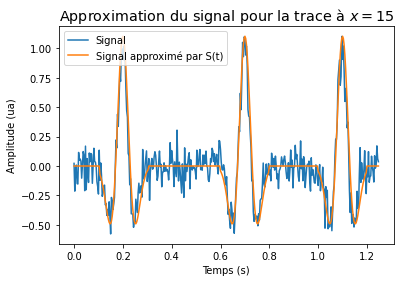

In [500]:
xdonne = 15
x = xdonne*10
#fig, ax = plt.subplots()
plt.plot(at, gpanel[:,xdonne],label = "Signal");

# Pb avec les sigma et mu
signal_const = [1/5*ondelette_ind2(t1, p1, t, x, 0.03, 0.7) + 1/5*ondelette_ind2(t2, p2, t, x, 0.03, 0.2) + 1/5*ondelette_ind2(t3, p3, t, x, 0.03, 1.1)  for t in at]

# Gérer le chevauchement
""" for i in range(len(signal_const)):
    if signal_const[i] > max(gpanel[:,xdonne]) :
        signal_const[i] = max(gpanel[:,xdonne])  """
    
plt.plot(at, signal_const, label = "Signal approximé par S(t)")
plt.ylabel('Amplitude (ua)')
plt.xlabel('Temps (s)')
plt.legend()
plt.title("Approximation du signal pour la trace à $x=15$", fontsize = "x-large")
plt.show();

## Détermination des $(t_i,p_i)$

A partir de la première trace en $x_0=0$, calculer pour plusieurs temps et pour plusieurs pentes les sommations suivantes :

$$F(t,p) = \Bigg[\int \,u(t-p\cdot(x-x_0),x)\,dx\Bigg]^2$$

A quoi correspondent les maxima de $F$? En déduire les valeurs de $(t_i,p_i)$ pour $i\in[1,3]$. Bien choisir l'échantillonnage en temps et en pente pour une bonne détermination des $(t_i,p_i)$. 

Remarques :
* Par exemple, il peut être intéressant d'interpoler linéairement entre 2 points voisins si $t - p\cdot(x-x_0)$ ne tombe pas sur un point de grille ;
* Pour une bonne estimation, l'échantillonnage des pentes doit être suffisament fin ;
* Il est possible de reprendre une idée du TP "synthèse musicale" pour sélectionner itérativement les meilleurs $(t_i,p_i)$, mais ici en 2d.

Reconstruire les données à partir de l'équation (1) et des valeurs $(t_i,p_i)$ sélectionnées. Commentez les résultats.

<font color = "blue">
    
Les valeurs coprrespondant au maximum de $F(t,p)$ pour un couple $(t,p)$ donné correspondent aux valeurs d'annulation de la fonction $u(t-p(x-x_0),x)$ et nous donnent donc les couples $(t_i, p_i)$.

In [501]:
trace_0 = gpanel[:,0]

In [502]:
def indice(t) :
    if 0 <= t <= at[-1] :
        return int(t/0.003125)
    else : 
        return False

In [503]:
def F(t,p, x0) :
    somme = 0
    for indice_x in range(nx) :
        x = ax[indice_x]
        indice_t = indice(t-p*(x-x0))
        if indice_t != False :
            somme += gpanel[indice_t, indice_x]
    return somme**2

In [504]:
# Données autour desquelles il faut chercher
T = [0.4, 1.1, 0.2]
P = [-0.002, 0.006, -0.006]

### Test 1

In [505]:
P_1 = np.linspace(P[0]-10**(-3), P[0]+10**(-3), 100)
T_1 = np.linspace(T[0]-0.1, T[0]+0.1, 100)

In [506]:
max1 = 0
result1 = [0,0]
values = []
for t, p in product(T_1, P_1) :
    value = F(t, p, 0)
    values.append(value)
    if value > max1 :
        max1 = value
        result1 = [t,p]
print(result1)
t1,p1 = result1[0],result1[1]

[0.40101010101010104, -0.00198989898989899]


### Test 2

In [507]:
P_2 = np.linspace(P[1]-10**(-3), P[1]+10**(-3), 100)
T_2 = np.linspace(T[1]-0.1, T[1]+0.1, 100)

In [508]:
max2 = 0
result2 = [0,0]
for t,p in product(T_2, P_2) :
    value = F(t, p, 0)
    if value >= max2 :
        max2 = value
        result2 = [t,p]
print(result2)
t2,p2 = result2[0],result2[1]

[1.098989898989899, 0.00596969696969697]


### Test 3

In [509]:
P_3 = np.linspace(P[2]-10**(-3), P[2]+10**(-3), 100)
T_3 = np.linspace(T[2]-0.1, T[2]+0.1, 100)

In [510]:
max3 = 0
result3 = [0,0]
for t, p in product(T_3, P_3):
    value = F(t, p, 0)
    if value >= max3 :
        max3 = value
        result3 = [t,p]
print(result3)
t3,p3 = result3[0],result3[1]

[0.19898989898989902, -0.00598989898989899]


### Résultats des tests 

<font color = "blue">

On peut voir que pour chaque test, on retrouve bien en regardant dans un intervalle où doit se trouver la pente et le temps à l'origine que les valeurs estimées précédemment en partie introductive sont pertinentes. En effet, il s'agit bien du maximum lié au couple $(t,p)$.

### Reconstruction des données

<font color = "blue">

### Reconstruction de l'ensemble des données pour confirmer le modèle

In [511]:
result = [[]for i in range (400)]
for it in range(nt):
    for ix in range(nx):
        res = S(t1, p1, at[it], ax[ix])+S(t2, p2, at[it], ax[ix])+S(t3, p3, at[it], ax[ix])
        if res > 1 :
            res = 1
        result[it].append(res)
signal = np.array(Sol)
signal.shape

(400, 30)

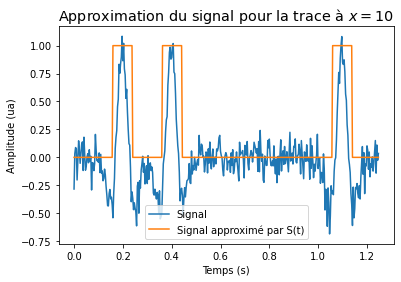

In [512]:
#fig, ax = plt.subplots()
plt.plot(at, gpanel[:,0],label = "Signal");
plt.plot(at, signal[:,0], label = "Signal approximé par S(t)")
plt.ylabel('Amplitude (ua)')
plt.xlabel('Temps (s)')
plt.legend()
plt.title("Approximation du signal pour la trace à $x=10$", fontsize = "x-large")
plt.show();

(400, 30)

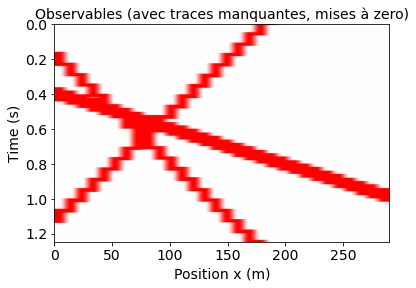

In [513]:
vmax = np.max(np.abs(signal))
fig = plt.figure()
plt.imshow(signal,extent=[ax[0],ax[-1],at[-1],at[0]],aspect='auto')
plt.title('Observables (avec traces manquantes, mises à zero)', fontsize = labelsize)
av.set_ylabel("Time (s)", fontsize = labelsize)
pltxlabel("Position x (m)", fontsize = labelsize)
av.tick_params(axis='both', which='major', labelsize=labelsize)
plt.clim([-vmax,vmax])
plt.set_cmap('bwr')
gpanel.shape

# ancienne version

In [514]:
def reconstruction_S_indic(x):
    """ Fonction qui permet de reconstruire le signal à partir des indicatrices vues précédemment à partir d'un x donné"""
    signal_reconst = []
    for t in at :
        signal_reconst.append(S(t1, p1, t, x)+S(t2, p2, t, x)+S(t3, p3, t, x))
    
    #Gérer les chevauchements entre les signaux
    for i in range(len(signal_reconst)):
        if signal_reconst[i] > 1 :
             signal_reconst[i] = 1
    
    return signal_reconst

In [515]:
#Tentative de comprendre l'échec
signal_reconstruit_indicatrice_test = []
for ix in range(nx) :
    signal_reconstruit_indicatrice_test.append(reconstruction_S_indic(ax[ix]))

# reconstruire les données tout avec l'approximation pour voir si ça marche
# reconstruire seulement les données manquantes
len(signal_reconstruit_indicatrice_test[2])

400

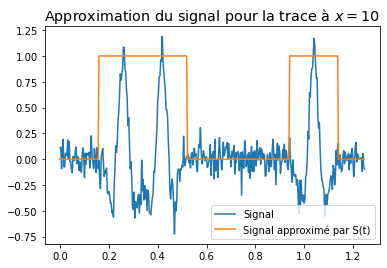

In [516]:
#fig, ax = plt.subplots()
plt.plot(at, gpanel[:,1],label = "Signal");
plt.plot(at, signal_reconstruit_indicatrice_test[1], label = "Signal approximé par S(t)")
#ax.set_ylabel('Amplitude (ua)')
#ax.set_xlabel('Temps (s)')
plt.legend()
plt.title("Approximation du signal pour la trace à $x=10$", fontsize = "x-large")
plt.show();

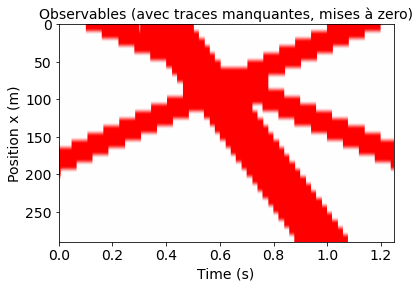

In [517]:
# Display of the rebuilt data
vmax = np.max(np.abs(signal_reconstruit_indicatrice_test))
fig = plt.figure()
av = plt.subplot(111)
plt.imshow(signal_reconstruit_indicatrice_test,extent=[at[0],at[-1],ax[-1],ax[0]],aspect='auto')
plt.title('Observables (avec traces manquantes, mises à zero)', fontsize = labelsize)
av.set_xlabel("Time (s)", fontsize = labelsize)
av.set_ylabel("Position x (m)", fontsize = labelsize)
av.tick_params(axis='both', which='major', labelsize=labelsize)
plt.clim([-vmax,vmax])
plt.set_cmap('bwr')

<font color = "blue">

### Reconstruction des données manquantes par l'approche 1

In [485]:
one = np.ones(400)
ind_missing = []
for i in range (nx):
    if (gpanel[:,i]<one).sum()==400 :
        ind_missing +=[i]

In [488]:
gpanel_cor = np.copy(gpanel)
for ind in ind_missing :
    gpanel_cor[:,ind] = signal[:,ind]

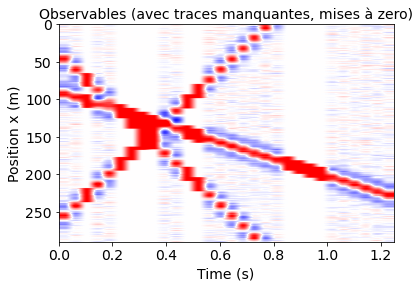

In [489]:
vmax = np.max(np.abs(signal))
fig = plt.figure()
av = plt.subplot(111)
plt.imshow(gpanel_cor,extent=[at[0],at[-1],ax[-1],ax[0]],aspect='auto')
plt.title('Observables (avec traces manquantes, mises à zero)', fontsize = labelsize)
av.set_xlabel("Time (s)", fontsize = labelsize)
av.set_ylabel("Position x (m)", fontsize = labelsize)
av.tick_params(axis='both', which='major', labelsize=labelsize)
plt.clim([-vmax,vmax])
plt.set_cmap('bwr')

# Approche 2 : Analyse des Données dans le Domaine de Fourier 2d

## Approche théorique
Calculer la transformée de Fourier 2d de $u$ à partir de la transformée de Fourier 1d de $S$. Expliquer toujours à partir des équations pourquoi on s'attend à avoir 3 événements linéaires dans le domaine de Fourier. Pourquoi tous ces événements passent-ils par l'origine $(0,0)$ dans le domaine de Fourier? Donner une expression quantitative entre les pentes dans le domaine de Fourier et les pentes $p_i$. 

## Implémentation
Représenter la transformée de Fourier 2d et bien préciser les axes. Indiquer à quoi correspondent la fréquence maximale et le nombre d'onde maximal. Faire le lien entre les 3 événements dans l'espace $(t,x)$ et ceux dans l'espace de Fourier. Expliquer ce qu'il se passe aux bords dans le domaine de Fourier. N'hesitez pas à zoomer autour de la position centrale dans le domaine de Fourier.

Remarques : 
* Le nombre d'onde (en 1/m) est l'équivalent de la fréquence pour l'axe spatial ;
* Le signal a très peu d'énergie pour les fréquences au-delà de 20 Hz. 

(400, 30)

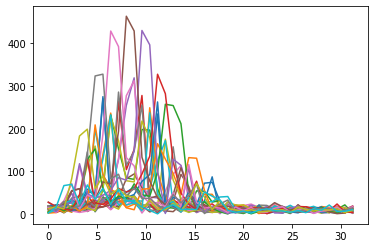

In [412]:
panel_dense_fft = np.fft.fft2(panel_dense)
freq = np.fft.fftfreq(nt, at[1]-at[0])
w = np.fft.fftfreq(nx, ax[1]-ax[0])
plt.plot(freq[:nt//10], np.abs(panel_dense_fft[:nt//10]))
#plt.plot(w, np.abs(panel_dense_fft[30,:]))
panel_dense_fft.shape

## Définition d'un masque dans le domaine de Fourier 2d
On note $f$ la fréquence et $k_x$ le nombre d'onde. Dans le domaine de Fourier 2d, on souhaite définir un masque avec des 1 qui couvrent les événements principaux. A partir de $(f,k_x)=(0,0)$, faire des sommations selon différentes pentes (dans le domaine de Fourier, après avoir pris le module des valeurs complexes) et tracer la valeur de ces sommes en fonction de la pente. On s'attend à ce que 3 valeurs ressortent. Calculer une fonction qui sélectionne automatiquement ces valeurs et construire un masque dans le domaine de Fourier 2d qui vaut 1 autour de ces trois valeurs principales et 0 en dehors.

Comment faire pour prendre en compte ce qui se passe aux bords dans le dommaine de Fourier?

## Application du masque et analyse des résultats
Appliquer le masque (sur les données après transformée de Fourier 2d, sans prendre le module des valeurs), puis appliquer la transformée de Fourier inverse. Commenter les résultats (comparaison à la fois dans les domaines $(t,x)$ et $(f,k_x)$. Si nécessaire, revenir à la question précédente pour changer le masque et avoir une meilleure interpolation des données. Expliquer ces changements. Discuter de l'importance du masque.

# Approche 3 : Amélioration de l'Approche 2 (*partie optionelle*)
Le résultat de l'approche 2 montre en pratique que les données prédites après transformée de Fourier inverse 2d ne calent pas parfaitement aux données observées (pour les traces non nulles). C'est un inconvénient, mais d'un autre côté, ceci offre la possibilité d'aller plus loin pour forcer un bon calage.

Pour cela, nous définissons une fonction objective

$$
J[p] = \frac{1}{2}||T p - p^\mathrm{obs}||_2^2 + \frac{\alpha}{2} || F p ||_M^2
$$

ou $p(t,x)$ sont les signaux (sur toutes les traces), $T$ l'operateur qui vaut 1 pour des traces existantes et 0 sinon, $p^\mathrm{obs}(t,x)$ les observables (i.e. pour les traces non nulles), $F$ la transformee de Fourier 2d. La norme $||p||_2^2 = \sum_x \sum_t |p(t,x)|^2$ et $||q||_M^2= \sum_x \sum_t M(f,k_x)|q(f,k_x)|^2$, avec $M$ un masque défini dans le domaine de Fourier. Le poids $\alpha$ est une pondération entre les deux termes.

On cherche à minimiser $J$. Le meilleur $p$ sera celui qui minimise l'écart aux données (premier terme) tout en minimisant l'énergie dans le domaine de Fourier 2d (avec présence du masque). Par rapport au masque $M_0$ des questions 2 et 3, on prend ici $M=1 - M_0$. Expliquer pourquoi.

La minimisation se fait de manière itérative, avec la fonction ```minimize``` de scipy (```from scipy.optimize import minimize```). Parmi plusieurs possibilités, je suggère de prendre une approche de gradient conjugué (CG). La minisation va se faire selon :

```
res = minimize(defj, p0, method='CG', jac=defg, \
        options={'disp': True, 'maxiter':niter})
```

Il faut donc créer une valeur initiale pour $p$ (ici ```p0```), spécifier le nombre d'itérations ```niter``` et surtour définir la fonction objective ```defj()``` et son gradient par rapport à $p$ ```defg()```.

Le gradient est donné par 

$$
\frac{\partial J}{\partial p} = T^t(T p - p^\mathrm{obs}) + \alpha F^t M F p
$$

où $^t$ est l'opérateur transposé. L'application de $T^t$ correspond donc à insérer des traces nulles là où il n'y a pas d'observables et $F^t$ est la transformée de Fourier inverse.

Construire les fonctions ```defj()``` et ```defg()```. Attention, ```minimize``` attend que ```p``` soit sous forme de vecteur. On peut donc utiliser ```np.transpose(p,nt*nx)``` (voir plus bas dans l'exemple).

$\alpha$ est une pondération dont la valeur est à tester.

La valeur initiale ```p0``` de $p$ peut être prise égale à ```gpanel``` (le tableau lu au debut du code).

Faire plusieurs itérations. Analyser les résultats à la fois dans le domaine temporel et dans le domaine de Fourier 2d. Etudier l'importance de la régulariation.

In [ ]:
# Exemple de structure du code
def defj(p):
    """Definition of the objective function"""
    # Retrieve the size
    pan = np.reshape(p,[nt,nx])
    j0  = 0.
    #
    # ADD
    #
    return j0
    
    
def defg(p):
    """Definition of the gradient of the objective function"""
    # Retrieve the size
    pan = np.reshape(p,[nt,nx])
    grd = np.zeros([nt,nx])
    #
    # ADD
    #
    # Return with vector size
    return np.reshape(grd,nt*nx)

In [ ]:
# Iterative mininisation (example)
niter = 10 # number of iterations
p0 = np.reshape(np.copy(gpanel),nt*nx)
res = minimize(defj, p0, method='cg', \
                jac=defg, \
                options={'disp': True, 'maxiter':niter})
# Final panel
panelf = np.reshape(res.x,[nt,nx])

# Analyse des Limites des Approches
Proposer une analyse des avantages et limites des approches 1, 2 (et 3 le cas échéant). Tester la robustesse au travers de d'autres applications. Par exemple, vous pouvez :
* Ajouter du bruit (gaussien ou non) sur les données ;
* Avoir des événements linéaires avec des amplitudes différentes ;
* Ajouter des délais en temps pour chaque position en $x$ et comparer les résultats ;
* Rnlever encore plus de données en entrée (plus de traces blanches) ;
* Application sur des images totalement différentes.

**Cette dernière partie est très ouverte, et je fais appel à votre créativité.**

reprendre la 1 ou 2 : faire des variations, changer les données en entrée
modifier l'image en décalant au hasard avec un delta t
trouver une autre image mettre des parties blanches etc et voir pq ca ne marche pas